In [1]:
from deepsudoku.reinforcement_learning import visualize, agents
import torch
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Sudoku Environment avaible at gymnasium as 'Sudoku-v0'.


/home/felix/anaconda3/envs/sudoku_torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
agent = agents.get_sudoku_agent()

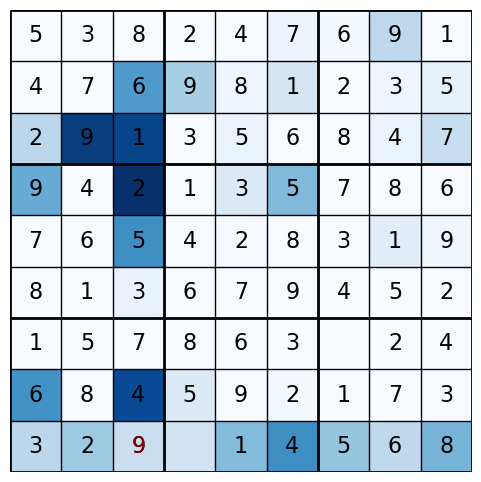

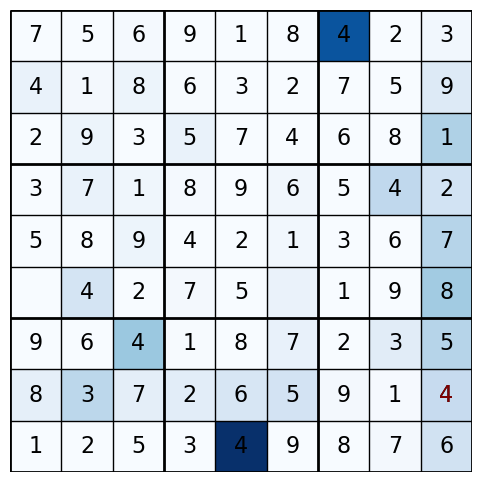

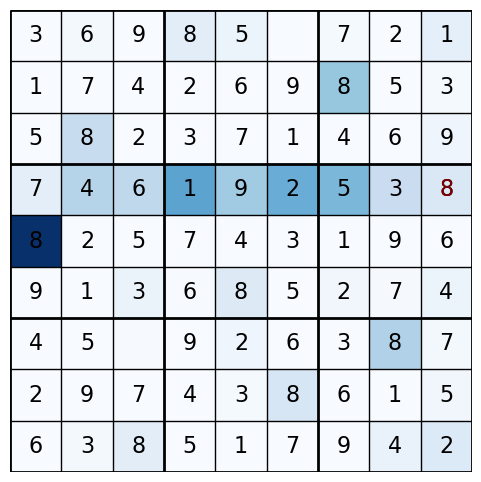

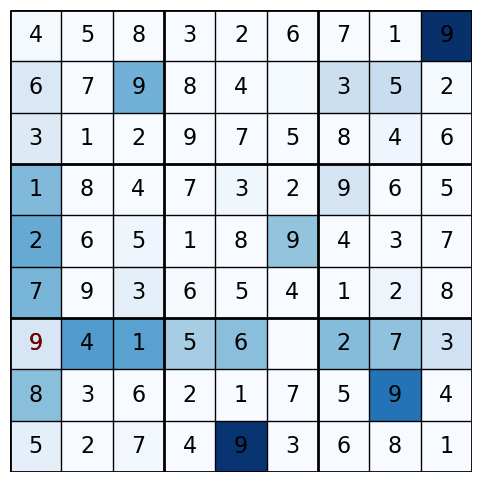

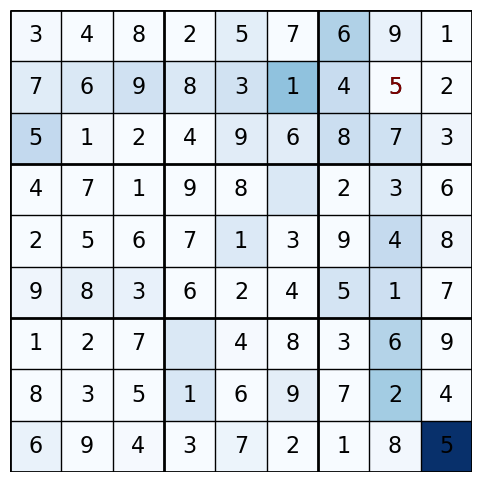

In [3]:
env = gym.make("Sudoku-x2", upper_bound_missing_digist = 3)

for _ in range(5):

    fig = visualize.farm_and_viz_integrated_gradients(env,agent)
    plt.show()

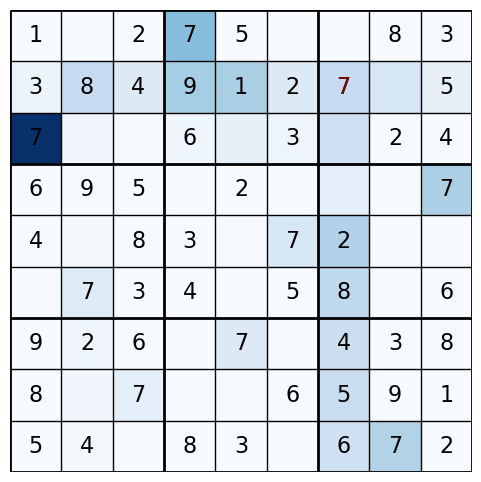

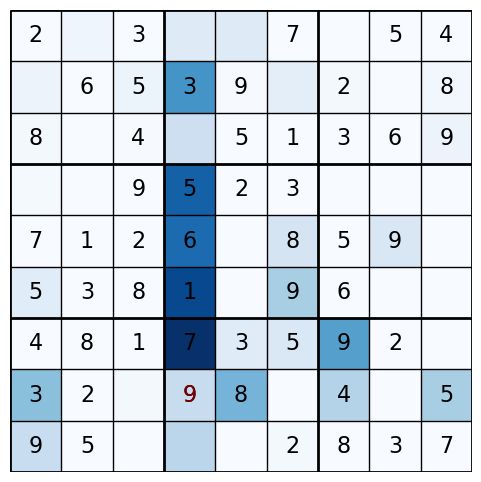

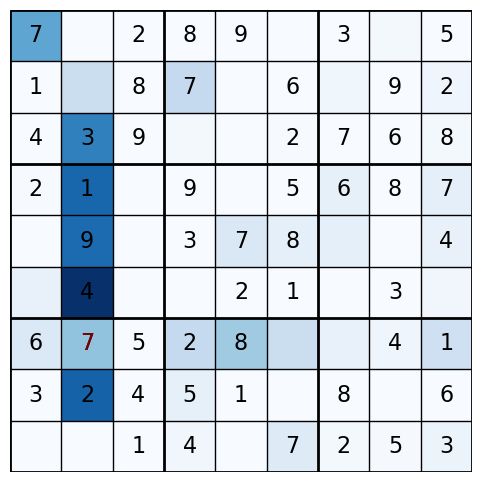

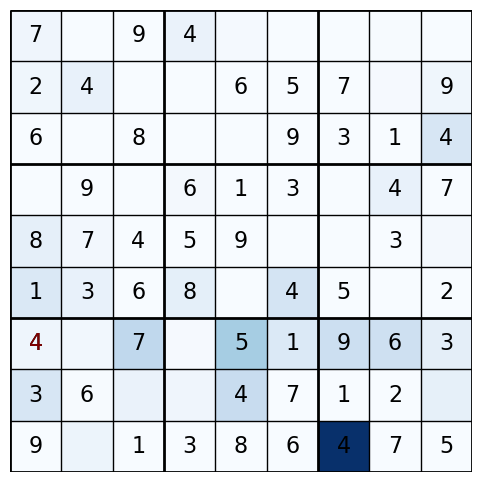

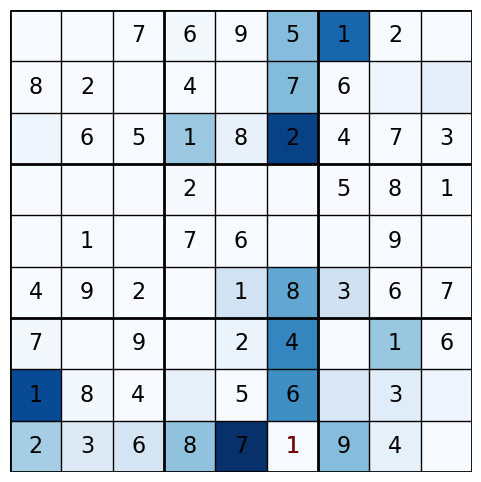

In [4]:
env = gym.make("Sudoku-x2",)

for _ in range(5):

    fig = visualize.farm_and_viz_integrated_gradients(env,agent)
    plt.show()

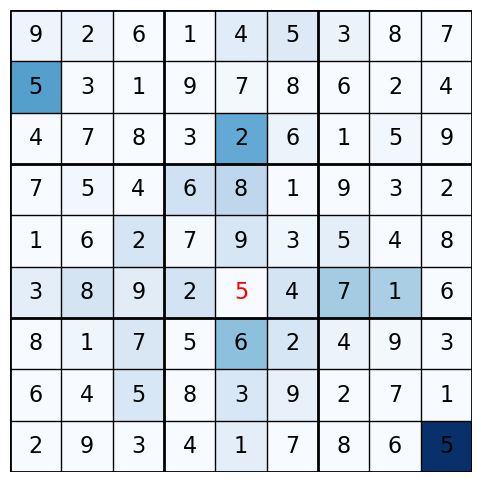

In [8]:
ani = visualize.get_animation_of_full_playthrough(agent, env)
ani.save('animation.gif', )

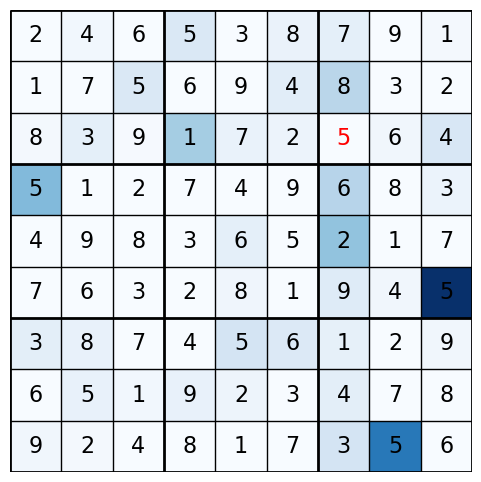

In [9]:
ani = visualize.get_animation_of_full_playthrough(agent, env)
ani.save('animation.mp4', fps = 0.7)